## Category: Getting Started

### Task 1: Import Modules and Libraries

In [25]:
import pandas as pd 
import seaborn
import matplotlib
import nltk
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
import numpy as np 
import scipy 
from scipy.sparse import hstack
import collections
from collections import defaultdict, Counter 
import math
nltk.download("punkt")
nltk.download("stopwords")
from nltk.corpus import stopwords
from tqdm import tqdm
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Category: Loading Data

### Task 2: Load and Explore the Genes and Variations Dataset

In [2]:
# print(os.listdir('/usercode/'))
df_var = pd.read_csv('/usercode/training_variants')
print(df_var.shape)
print([df_var[col].dtype for col in df_var.columns])
display(df_var.head())
print([len(df_var[col].drop_duplicates()) for col in df_var.columns])

(3321, 4)
[dtype('int64'), dtype('O'), dtype('O'), dtype('int64')]


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


[3321, 264, 2996, 9]


### Task 3: Load the Text Dataset

In [3]:
df_txt = pd.read_csv("/usercode/training_text", sep='\|\|', skiprows=1, names=['ID', 'Text'])

print(df_txt.shape)
print(df_txt.columns)
display(df_txt.head())

/tmp/ipykernel_129/4148034272.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_txt = pd.read_csv("/usercode/training_text", sep='\|\|', skiprows=1, names=['ID', 'Text'])


(3321, 2)
Index(['ID', 'Text'], dtype='object')


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## Category: Text Pre-processing

### Task 4: Define the Function for Pre-processing

In [4]:
import regex as re 

set_all_words = set(stopwords.words('english'))

def preprocess_data(txt):
    if not isinstance(txt, str):
        return None
    pattern = r'^A-Za-z0-9\s'
    cleaned = re.sub(pattern, '', txt)
    cleaned = re.sub(r'\s+', ' ', txt)
    cleaned = cleaned.lower()
    tokenized = word_tokenize(cleaned)
    overlap_set = [strr for strr in tokenized if strr in set_all_words]
    return ' '.join(overlap_set)

print(preprocess_data('hello how are you was not'))

how are you was not


### Task 5: Pre-process the Data

In [5]:
tqdm.pandas()
df_txt['Text'] = df_txt.progress_apply(lambda row: preprocess_data(row['Text']), axis=1)

100%|██████████| 3321/3321 [04:22<00:00, 12.63it/s]


### Task 6: Merge Datasets, Clean, and Impute Values

In [6]:
df_merged = pd.merge(df_var, df_txt, on='ID', how='left')
nan_rows = df_merged[df_merged['Text'].isna()].index
df_merged.loc[nan_rows,'Text'] = df_merged.loc[nan_rows, 'Gene'] + ' ' +  df_merged.loc[nan_rows, 'Variation']
for col in ['Gene', 'Variation']:
    df_merged[col] = df_merged[col].str.replace(r'\s+', '_', regex=True)
df_merged

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating_Mutations,1,a of out as of the for which no has been and n...
1,1,CBL,W802*,2,is a of with a of and is an and in and we the ...
2,2,CBL,Q249E,2,is a of with a of and is an and in and we the ...
3,3,CBL,N454D,3,has that is a by which in be to to in we a to ...
4,4,CBL,L399V,4,in the have been in but their have been the at...
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,are a of by and to from with to is in the whic...
3317,3317,RUNX1,A122*,1,are a of by and to from with to is in the whic...
3318,3318,RUNX1,Fusions,1,the and to a of and that for in during the in ...
3319,3319,RUNX1,R80C,4,the is the most for in in have in the as of in...


## Category: Train-test Split

### Task 7: Perform Train-test Split

In [7]:
train_df, test_df = train_test_split(df_merged, test_size=0.2, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)
label_col = 'Class'
y_train = train_df['Class'].values
y_valid = valid_df['Class'].values
y_test = test_df['Class'].values


### Task 8: Check Distribution of Dataset

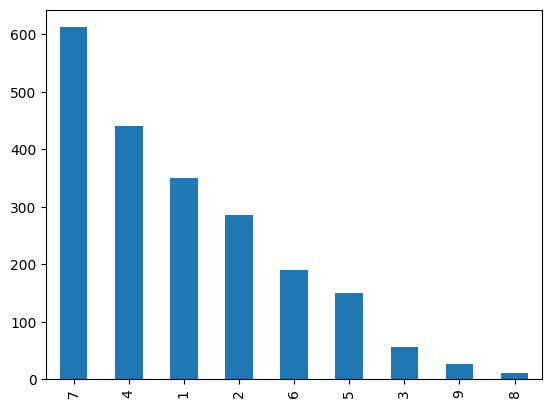

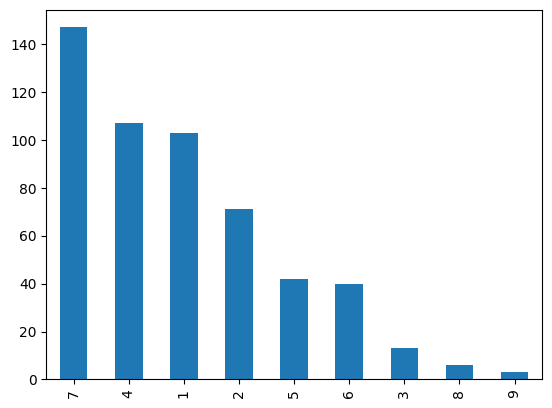

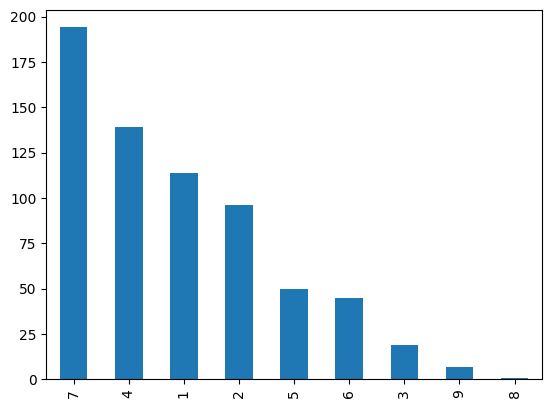

In [8]:
import matplotlib.pyplot as plt     

for df, lbl in zip([train_df, valid_df, test_df], ['train', 'valid', 'test']):
    df['Class'].value_counts().plot(kind='bar')
    plt.show()

## Category: Measure Performance Using Random Model

### Task 9: Define a Function to Plot Performance Matrices

In [9]:
import seaborn as sns
def plot_performance_matrices(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
    for mat in [
        C, C/C.sum(axis=0, keepdims=True), C/C.sum(axis=1, keepdims=True)
    ]:
        sns.heatmap(mat)
        plt.show()   

### Task 10: Measure Metrics from a Dummy Baseline Model

===>  train


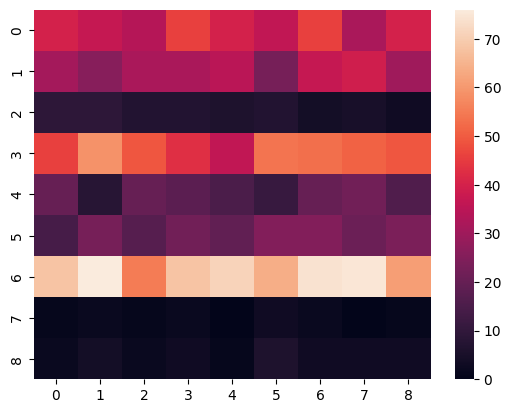

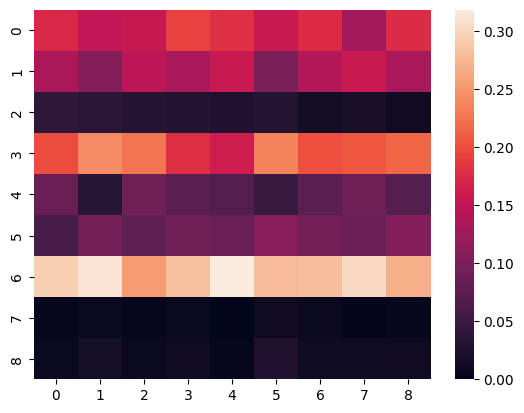

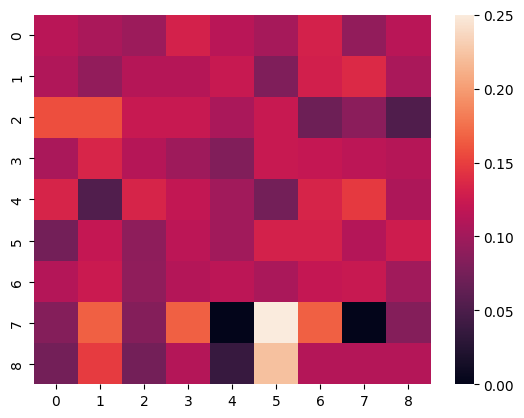

log_loss= 2.4681169136588914
===>  val


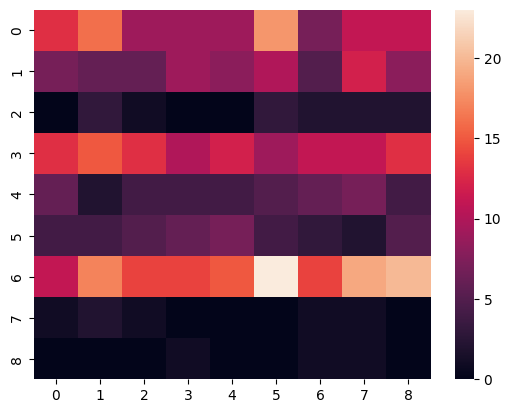

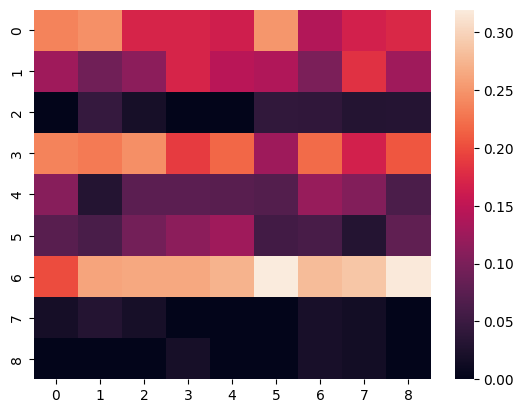

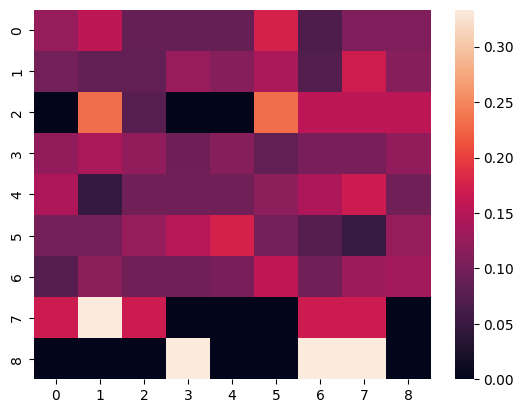

log_loss= 2.539801775479746


In [10]:
num_classes = len(df['Class'].unique())
for y_true, clss_lbl in zip(
    [train_df['Class'], valid_df['Class']],
    ['train', 'val']
):
    print('===> ', clss_lbl)
    x = np.random.rand(len(y_true), num_classes)
    x /= np.sum(x, axis=1)[:, np.newaxis]
    y_pred = np.argmax(x, axis=1) + 1
    # print(y_pred)
    plot_performance_matrices(y_true, y_pred)
    print('log_loss=', log_loss(y_true.values, x))

## Category: Encode the Features

### Task 11: Define the Functions for Response Coding

In [11]:
def multiclass_response_encoding(df: pd.DataFrame, feature: str, alpha: float):
    df_counts = df.groupby([feature, 'Class'])['ID'].count().reset_index().rename(
        columns={'ID': 'count'}
    )
    df_fv_counts = df_counts.groupby(feature)['count'].sum().reset_index().rename(
        columns={'count': 'FV_count'}
    )
    df_counts = pd.merge(df_counts, df_fv_counts, on=feature, how='left')
    df_counts['response_code_prob'] = (df_counts['count']+alpha).divide(
        (df_counts['FV_count'] + alpha * num_classes).values
    ).values

    df_class = pd.DataFrame({'Class': np.arange(num_classes)+1, 'common': [1]*num_classes})
    df_feat = pd.DataFrame({feature: df[feature].unique()})
    df_feat['common'] = 1
        
    df_counts = pd.merge(
        df_counts, 
        pd.merge(df_feat, df_class, on='common', how='outer'), 
        on=[feature, 'Class'], how='outer'
    )

    df_counts = df_counts.sort_values(by=[feature, 'Class']).reset_index(drop=True)
    df_counts["response_code_prob"] = df_counts["response_code_prob"].fillna(0)
    # display(df_counts)
    return {fv: df_counts.loc[df_counts[feature]==fv,'response_code_prob'].values for fv in df_counts[feature].unique()}

def encode_feature(df, feature, response_code_probs):
    default_prob = [1/num_classes]*num_classes
    response_coded_feature = df[feature].map(lambda x: response_code_probs.get(x, default_prob))
    return response_coded_feature

### Task 12: Run the Function on 'Gene' and 'Variation' Features

In [12]:
for feat_col in ['Gene', 'Variation']:
    response_code_probs = multiclass_response_encoding(train_df, feat_col, alpha=1)
    for df in [train_df, valid_df, test_df]:
        df[f'{feat_col}_multiclass_encoded'] = encode_feature(df, feat_col, response_code_probs)
df

,ID,Gene,Variation,Class,Text,Gene_multiclass_encoded,Variation_multiclass_encoded
1057,1057,EWSR1,EWSR1-FEV_Fusion,2,as a of the is to a of in in can be to of the ...,"[0.0, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0,...","[0.1111111111111111, 0.1111111111111111, 0.111..."
812,812,ERCC2,V536M,1,the of for will to an of as an we that of a in...,"[0.55, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]","[0.1111111111111111, 0.1111111111111111, 0.111..."
2658,2658,BRCA1,K50E,6,of the are a of and the and this is to be for ...,"[0.21910112359550563, 0.0, 0.06741573033707865...","[0.1111111111111111, 0.1111111111111111, 0.111..."
809,809,ERCC2,R631C,1,the of for will to an of as an we that of a in...,"[0.55, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0]","[0.1111111111111111, 0.1111111111111111, 0.111..."
862,862,ABL1,F359C,2,for with who or are to be when which to the an...,"[0.0, 0.6538461538461539, 0.0, 0.0, 0.0, 0.0, ...","[0.1111111111111111, 0.1111111111111111, 0.111..."
...,...,...,...,...,...,...,...
787,787,ERBB4,V348L,3,to the of have in the the of in here we have i...,"[0.0, 0.1111111111111111, 0.0, 0.0, 0.0, 0.166...","[0.1111111111111111, 0.1111111111111111, 0.111..."
2206,2206,PTEN,T131S,3,the and is in in of its by of the which the of...,"[0.02040816326530612, 0.0, 0.04081632653061224...","[0.1111111111111111, 0.1111111111111111, 0.111..."
56,56,PTPRT,V995M,4,is a by the of t it is with and our that up to...,"[0.3684210526315789, 0.0, 0.0, 0.2631578947368...","[0.1111111111111111, 0.1111111111111111, 0.111..."
1983,1983,CTNNB1,W383R,7,in of are for that have but of such to of be a...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6666666666666...","[0.1111111111111111, 0.1111111111111111, 0.111..."


### Task 13: Count Words in Text Field

In [13]:
tqdm.pandas()
def count_words(df):
    return dict(Counter(df['Text'].apply(lambda x: x.split()).explode().tolist()))

def class_count_words(df, grpby_col=None):
    if grpby_col is None:
        return count_words(df)
    return df.groupby(grpby_col).progress_apply(count_words).tolist()

### Task 14: Define a Function for Response Coding

In [14]:
total_dict = count_words(train_df)
print(total_dict)
total_dict_words = np.array(list(total_dict.keys()))
class_dicts = class_count_words(train_df, 'Class')

{'most': 19214, 'with': 246658, 'to': 357614, 'the': 959287, 'of': 785502, 'and': 586285, 'for': 176079, 'are': 92617, 'we': 88576, 'on': 71743, 'from': 81405, 'who': 6503, 'or': 101032, 'in': 575778, 'were': 164904, 'a': 290720, 'that': 183268, 'same': 10535, 'be': 62337, 'have': 51353, 'all': 39232, 'these': 72563, 'some': 11511, 'than': 25231, 'been': 40652, 'our': 29846, 'is': 135947, 'before': 4533, 'after': 21129, 'this': 84003, 'had': 21920, 'as': 123049, 'was': 135055, 'by': 135300, 'which': 49638, 'an': 57797, 'did': 11383, 'not': 68159, 'more': 22745, 'at': 75404, 'its': 20325, 'but': 28917, 'into': 17857, 'both': 26635, 'their': 18535, 'those': 11837, 'when': 12674, 'does': 4911, 'only': 21144, 'no': 21911, 'above': 4805, 'can': 22198, 'while': 7832, 'other': 32859, 'they': 10154, 'each': 21048, 'has': 29858, 'further': 12994, 'such': 18567, 'through': 12086, 'against': 9047, 'it': 30682, 'nor': 1198, 'there': 12609, 'between': 26540, 'i': 7306, 'should': 4944, 'if': 7307, '

100%|██████████| 9/9 [00:01<00:00,  5.23it/s]


In [15]:
# alpha = 1

# prob_total_words_class = np.zeros((len(total_dict), num_classes))
# for i, class_dict in enumerate(class_dicts): 
#     prob_total_words_class[:, i] = [
#         (
#             ((class_dict[word] if word in class_dict.keys() else 0)+alpha)/(total_dict[word]+alpha*num_classes)
#         ) for word in total_dict.keys()
#     ]


### Task 15: Run the Function on Text Field

In [16]:
def text_feat_respCode_class(diction):
    elements = np.array(list(diction.keys()))
    counts = np.array(list(diction.values()))
    # Use np.isin to create a boolean mask of where elements match
    mask = np.isin(total_dict_words, elements)
    # Use np.where to get indices of True values in the mask
    indices = np.where(mask)[0]
    return np.exp(
        np.sum(counts[:, np.newaxis] * np.log(prob_total_words_class[indices,:]), axis=0)
    )


def get_response_coding_mat(df):
    df =df.copy()
    df['Text_word_counter'] = df['Text'].apply(lambda x: Counter(x.split()))
    text_feature_responseCoding = np.zeros((len(total_dict), num_classes))
    # for i, class_dict in tqdm(enumerate(class_dicts)): 
    tqdm.pandas(position=0)
    text_feature_responseCoding = df['Text_word_counter'].progress_apply(text_feat_respCode_class)
    return np.stack(text_feature_responseCoding)

def generate_text_responsecoding(df, dict_list, total_dict, alpha):
    num_classes = 9  # Number of classes
    num_rows = df.shape[0]  # Number of rows in the DataFrame

    # Initialize a zeros array with shape (num_rows, num_classes)
    text_feature_rc = np.zeros((num_rows, num_classes))

    # Split the Text column into lists of words
    df['split_text'] = df['Text'].apply(lambda x: x.split())

    # Calculate response coding for each class
    for i in tqdm(range(num_classes)):
        row_index = 0
        for split_text in df['split_text']:
            # Use list comprehension and the map() method to apply the log probability calculations
            sum_prob = sum(
                map(
                    lambda word: math.log((dict_list[i].get(word, 0) + alpha) / (total_dict.get(word, 0) + 9*alpha)),
                    split_text
                )
            )
            # Calculate the final value for each row and class
            text_feature_rc[row_index, i] = math.exp(sum_prob / len(split_text))
            row_index += 1
 
            df.drop(['split_text'], axis=1)
           
    return text_feature_rc

In [17]:
alpha = 1
train_respcode_mat = generate_text_responsecoding(train_df, class_dicts, total_dict, alpha)
valid_respcode_mat = generate_text_responsecoding(valid_df, class_dicts, total_dict, alpha)
test_respcode_mat = generate_text_responsecoding(test_df, class_dicts, total_dict, alpha)

100%|██████████| 9/9 [00:17<00:00,  1.92s/it]


### Task 16: One-hot Encode the Features

In [18]:
# One-hot encoding the Gene feature
gene_vectorizer = CountVectorizer()
train_gene_oh = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_oh = gene_vectorizer.transform(test_df['Gene'])
cv_gene_oh = gene_vectorizer.transform(valid_df['Gene'])

# One-hot encoding the Variation feature
variation_vectorizer = CountVectorizer()
train_variation_oh = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_oh = variation_vectorizer.transform(test_df['Variation'])
cv_variation_oh = variation_vectorizer.transform(valid_df['Variation'])

# One-hot encoding the Text feature
# A minimum degree of freedom 3 is used to ensure that extremely rare words are not included while training
text_vectorizer = CountVectorizer(min_df=3)
train_text_oh = text_vectorizer.fit_transform(train_df['Text']) 
test_text_oh = text_vectorizer.transform(test_df['Text'])
cv_text_oh = text_vectorizer.transform(valid_df['Text'])

### Task 17: Normalizing the Text Feature

In [19]:
train_text_oh = normalize(train_text_oh, axis=0)
test_text_oh = normalize(test_text_oh, axis=0)
cv_text_oh = normalize(cv_text_oh, axis=0)

train_respcode_mat = normalize(train_respcode_mat, norm='l1', axis=1)
test_respcode_mat = normalize(test_respcode_mat, norm='l1', axis=1)
valid_respcode_mat = normalize(valid_respcode_mat, norm='l1', axis=1)


## Category: Check Feature Importances

### Task 18: Train Single Feature Models

In [20]:
base_clf = SGDClassifier(loss='log', alpha=0.001)

base_clf.fit(train_gene_oh, y_train)
calibrated_clf = CalibratedClassifierCV(base_clf, cv='prefit')
calibrated_clf.fit(cv_gene_oh, y_valid)
y_pred_valid = calibrated_clf.predict_proba(cv_gene_oh)
print(log_loss(y_valid, y_pred_valid))

base_clf.fit(train_variation_oh, y_train)
calibrated_clf = CalibratedClassifierCV(base_clf, cv='prefit')
calibrated_clf.fit(cv_variation_oh, y_valid)
y_pred_valid = calibrated_clf.predict_proba(cv_variation_oh)
print(log_loss(y_valid, y_pred_valid))


base_clf.fit(train_text_oh, y_train)
calibrated_clf = CalibratedClassifierCV(base_clf, cv='prefit')
calibrated_clf.fit(cv_text_oh, y_valid)
y_pred_valid = calibrated_clf.predict_proba(cv_text_oh)
print(log_loss(y_valid, y_pred_valid))


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


1.2481022073985562
1.677500695189997
1.762132342168802


## Category: Model Training

### Task 19: Stack the Features

In [21]:
def prep_gene_var_mult_enc(df):
    return np.stack(df.values)

train_gene_rc = prep_gene_var_mult_enc(train_df[f'Gene_multiclass_encoded'])
train_variation_rc = prep_gene_var_mult_enc(train_df[f'Variation_multiclass_encoded'])
test_gene_rc = prep_gene_var_mult_enc(test_df[f'Gene_multiclass_encoded'])
test_variation_rc = prep_gene_var_mult_enc(test_df[f'Variation_multiclass_encoded'])
cv_gene_rc = prep_gene_var_mult_enc(valid_df[f'Gene_multiclass_encoded'])
cv_variation_rc = prep_gene_var_mult_enc(valid_df[f'Variation_multiclass_encoded'])



In [22]:
train_gene_var_oh = hstack((train_gene_oh, train_variation_oh))
test_gene_var_oh = hstack((test_gene_oh, test_variation_oh))
cv_gene_var_oh = hstack((cv_gene_oh, cv_variation_oh))

train_x_oh = hstack((train_gene_var_oh, train_text_oh)).tocsr()
test_x_oh = hstack((test_gene_var_oh, test_text_oh)).tocsr()
cv_x_oh = hstack((cv_gene_var_oh, cv_text_oh)).tocsr()

train_gene_var_rc = np.hstack((train_gene_rc, train_variation_rc))
test_gene_var_rc = np.hstack((test_gene_rc, test_variation_rc))
cv_gene_var_rc = np.hstack((cv_gene_rc, cv_variation_rc))

train_x_rc = np.hstack((train_gene_var_rc, train_respcode_mat))
test_x_rc = np.hstack((test_gene_var_rc, test_respcode_mat))
cv_x_rc = np.hstack((cv_gene_var_rc, valid_respcode_mat))


### Task 20: Train a Logistic Regression Model

In [23]:
log_loss_list = []
alpha_list = np.logspace(-4, -2, num=7, base=10).tolist()
for alpha in alpha_list:
    base_cls = SGDClassifier(loss='log_loss', alpha=alpha, class_weight='balanced', penalty='l2', random_state=42)
    base_clf.fit(train_x_oh, y_train)
    calibrated_clf = CalibratedClassifierCV(base_clf, cv='prefit', method='sigmoid')
    calibrated_clf.fit(cv_x_oh, y_valid)
    valid_y_pred = calibrated_clf.predict_proba(cv_x_oh)
    log_loss_list.append(log_loss(y_valid, y_pred_valid, eps=1e-15))

best_alpha = alpha_list[np.argmin(log_loss_list)]
print('best alpha = ', best_alpha)
print('all log lossess = ', log_loss_list)
print('best valid log los = ', np.min(log_loss_list))

base_cls = SGDClassifier(loss='log_loss', alpha=best_alpha, class_weight='balanced', penalty='l2', random_state=42)
base_clf.fit(train_x_oh, y_train)
calibrated_clf = CalibratedClassifierCV(base_clf, cv='prefit')
calibrated_clf.fit(cv_x_oh, y_valid)
test_y_pred = calibrated_clf.predict_proba(test_x_oh)
print('test log loss = ', log_loss(y_test, test_y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/l

best alpha =  0.0001
all log lossess =  [1.762132342168802, 1.762132342168802, 1.762132342168802, 1.762132342168802, 1.762132342168802, 1.762132342168802, 1.762132342168802]
best valid log los =  1.762132342168802
test log loss =  1.1442958631747617


### Task 21: Train a Random Forest Model

In [45]:
rf_model = RandomForestClassifier(random_state=42)
calibrated_clf = CalibratedClassifierCV(rf_model, cv='prefit', method='sigmoid')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Use GridSearchCV for hyperparameter optimization
param_grid = {
    "n_estimators": [25, 50] + list(range(100, 1100, 200)),  # Number of trees in the forest
    "max_depth": [2, 10] + list(range(3, 10, 2)),  # Maximum depth of the trees
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="neg_log_loss",  # Use negative log-loss for scoring
    cv=cv,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Perform the grid search
grid_search.fit(np.vstack([train_x_rc, cv_x_rc]), np.hstack([y_train, y_valid]))

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")


Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END .......................max_depth=2, n_estimators=25; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=25; total time=   0.3s
[CV] END .......................max_depth=2, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=25; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.2s
[CV] END ......................max_depth=2, n_estimators=100; total time=   0.4s
[CV] END ......................max_depth=2, n_e

In [48]:
rf_model = RandomForestClassifier(
    max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'], random_state=42
)
rf_model.fit(train_x_rc, y_train)
calibrated_clf = CalibratedClassifierCV(rf_model, cv='prefit')
calibrated_clf.fit(cv_x_rc, y_valid)
valid_y_pred = calibrated_clf.predict_proba(cv_x_rc)
print('valid log loss = ', log_loss(y_valid, valid_y_pred))
test_y_pred = calibrated_clf.predict_proba(test_x_rc)
print('test log loss = ', log_loss(y_test, test_y_pred))

valid log loss =  1.392206604233219
test log loss =  1.3451948023787907
